# Data-Driven Insights and Predictive Clustering with KMeans and Gradient Boosting

New York City Airbnb Dataset Link : https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

# Importing Libraries

In [189]:
# importing libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Model evaluation and metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Model selection and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Clustering and classification models
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Statistical analysis
from scipy.stats import skew, kurtosis

# Dataset Loading and Cleaning

In [190]:
# Reading the Airbnb daatset and observing some initial samples
airbnb_data = pd.read_csv("/content/AB_NYC_2019.csv")
airbnb_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [191]:
# checking the count of available rows and columns
print(f"Rows present in the dataset : {airbnb_data.shape[0]}")
print(f"Columns present in the dataset : {airbnb_data.shape[1]}")

Rows present in the dataset : 48895
Columns present in the dataset : 16


This loaded data file includes all needed information to find out about hosts, geographical availability and necessary metrics to make predictions and draw conclusions. There are total 48895 samples and 16 features present.

In [192]:
# checking the null values count
print("- Null values present in the dataset -")
airbnb_data.isna().sum()

- Null values present in the dataset -


,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


* The 2456 null values are present in both 'last_review' and 'reviews_per_month' column which is very huge in count. So we can just drop those columns from the dataset.

* Again there are 12 and 13 values are null is name and host_name column respectively. These values can't be filled using Mode so the rows with null values can be directky dropped from the dataset.

In [193]:
# dropping the columns
airbnb_data = airbnb_data.drop(columns=['last_review', 'reviews_per_month'])

In [194]:
# dropping the rows and reseting index to ensure it's sequence after dropping rows
airbnb_data = airbnb_data.dropna(subset=['name', 'host_name'])
airbnb_data.reset_index(drop=True, inplace=True)

In [195]:
# again checking the null value count after handling them
airbnb_data.isna().sum().sum()

0

* Now there are no null values in the dataset

In [196]:
# checking the shape of the dataset after dropping the rows and columns
print(f"Shape of the dataset : {airbnb_data.shape}")

Shape of the dataset : (48858, 14)


In [197]:
# checking the duplicate records
print(f"Count of duplicate records : {airbnb_data.duplicated().sum()}")

Count of duplicate records : 0


* There are no duplicate records present in the dataset.

In [198]:
# Checking the asigned datatypes of the columns
airbnb_data.dtypes

,0
id,int64
name,object
host_id,int64
host_name,object
neighbourhood_group,object
neighbourhood,object
latitude,float64
longitude,float64
room_type,object
price,int64


* Data types are assigned correctly. Columns are of type int, float and object.

In [199]:
# Examining the data summary - mean, standard deviation and Inter quartile range
airbnb_data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,4.885800e+04,4.885800e+04,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000
mean,1.902335e+07,6.763169e+07,40.728941,-73.952170,152.740309,7.012444,23.273098,7.148369,112.801425
std,1.098289e+07,7.862389e+07,0.054528,0.046159,240.232386,20.019757,44.549898,32.964600,131.610962
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,9.475980e+06,7.818669e+06,40.690090,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000
50%,1.969114e+07,3.079133e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000
75%,2.915765e+07,1.074344e+08,40.763107,-73.936280,175.000000,5.000000,24.000000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000


* Average price 152.74 which indicates that most listings are moderately priced.
The average number of reviews is 23.27 it means there is healthy level of engagement with the listings.
* High standard deviation of 240.23 indicates variability in prices.
* The 50% of listings have minimum night requirements between 1 and 5 nights.

In [200]:
# Calculating skewness and kurtosis
cols = ['number_of_reviews', 'calculated_host_listings_count', 'availability_365']
for col in cols:
    print(f"{col}:")
    print(f"  Skewness: {airbnb_data[col].skew():.2f}")
    print(f"  Kurtosis: {airbnb_data[col].kurtosis():.2f}")
    print("-" * 30)

number_of_reviews:
  Skewness: 3.69
  Kurtosis: 19.54
------------------------------
calculated_host_listings_count:
  Skewness: 7.93
  Kurtosis: 67.50
------------------------------
availability_365:
  Skewness: 0.76
  Kurtosis: -1.00
------------------------------


* Skewness (2.59) and kurtosis (8.76) of 'number_of_reviews' column indicate right skewed distribution with heavy tails which means many properties have few reviews while a few have extremely high reviews.

* column 'Calculated Host Listings Count' has skewness of 7.99 and kurtosis of 72.36 it show highly skewed and heavy tailed distribution which suggests that most hosts manage few listings but some have exceptionally high counts.

* Availability_365 has skewness (0.77) and kurtosis (-1.07) it indicates uniform availability pattern with fewer extreme values.

# Exploratory Data Analysis

In [201]:
# checking the unique values
airbnb_data['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [202]:
# dropping the unnecessaary columns from the dataset
airbnb_data = airbnb_data.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood'])

In [203]:
airbnb_data.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


In [204]:
airbnb_data.shape

(48858, 9)

In [205]:
# Function - for examining average_price by room_type
def plot_bar_plot(data):
    # Creating bar plot
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x='room_type', y='price', data=data, estimator=lambda x: x.mean(),
                     errorbar=None, color='#BB9AB1')

    # Annotating each bar with the average price
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    fontsize=12, color='black',
                    xytext=(0, 10), textcoords='offset points')

    # Adding title and labels for clearity
    plt.title('Average Price by Room Type', fontsize=16, fontweight='bold')
    plt.xlabel('Room Type', fontsize=14)
    plt.ylabel('Average Price', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.show()

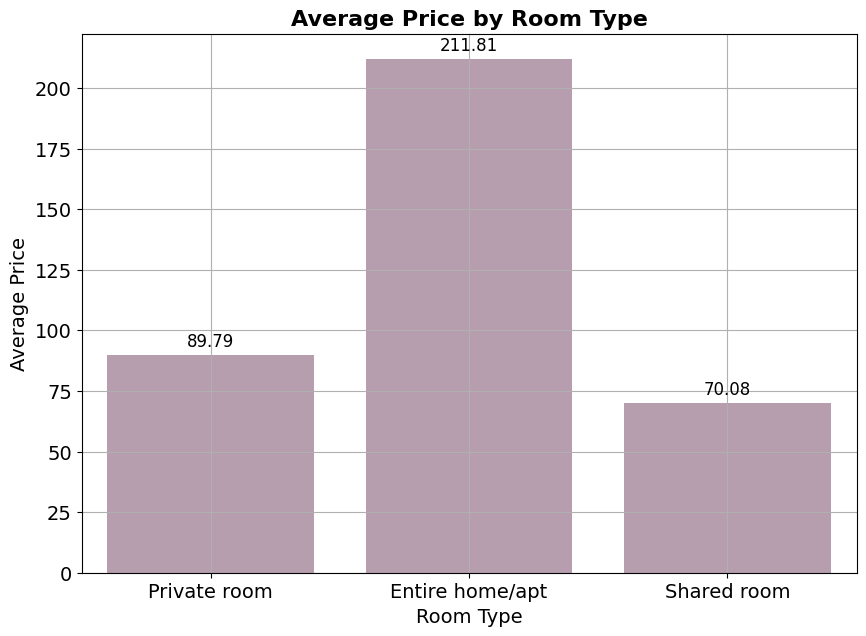

In [206]:
# Call the function
plot_bar_plot(airbnb_data)

* The above bar chart clearly shows that "Entire home/apt" has the highest average price than "Private room" and "Shared room", which suggests that guests in New York City are willing to pay a premium for the privacy and amenities associated with renting an entire home or apartment.
* "Shared room" has the lowest average price which means most economical choice for travelers on a budget.


In [207]:
# Function - for examining number_of_reviews by room_type
def plot_line_chart(data, x_column, y_column, color):
    # Creating line chart with
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=x_column, y=y_column, data=data, estimator='mean', marker='o', color=color)

    # Adding title and labels
    plt.title(f'Average {y_column} by {x_column}', fontsize=16, fontweight='bold')
    plt.xlabel(x_column, fontsize=14)
    plt.ylabel(f'Average {y_column}', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)

    # Annotating each point for clarity
    for index, value in enumerate(data.groupby(x_column)[y_column].mean()):
        plt.text(index, value, f'{value:.1f}', ha='center', va='bottom', fontsize=12, color='black')
    plt.show()

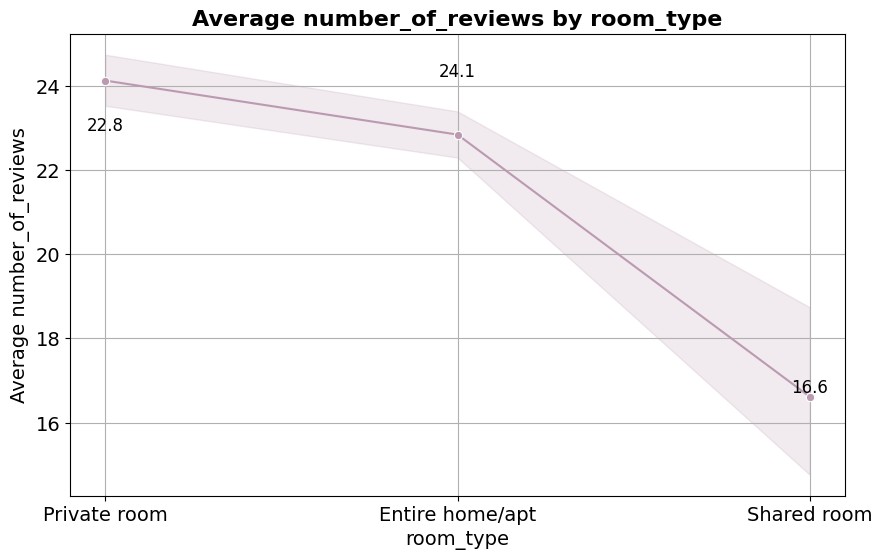

In [208]:
# Calling the function
plot_line_chart(airbnb_data, 'room_type', 'number_of_reviews', '#BB9AB1')

* The "Entire home/apt" has the highest average number of reviews followed by "Private room" and then "Shared room", this suggests that guests tend to have more positive experiences with entire homes/apartments, leading to higher review rates.

* "Shared room" has the lowest average number of reviews compared to the other two room types.


In [209]:
# Function - for examining correlation between numerical features
def plot_correlation_matrix(data, columns):

    # Calculating correlation matrix
    correlation_matrix = data[columns].corr()

    # Creating mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Creating heatmap for the correlation matrix
    plt.figure(figsize=(8, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap='twilight_shifted', fmt='.2f', cbar=True,
                annot_kws={'size': 14}, mask=mask, linewidths=0, linecolor='white')

    # Adding title and labels
    plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.show()

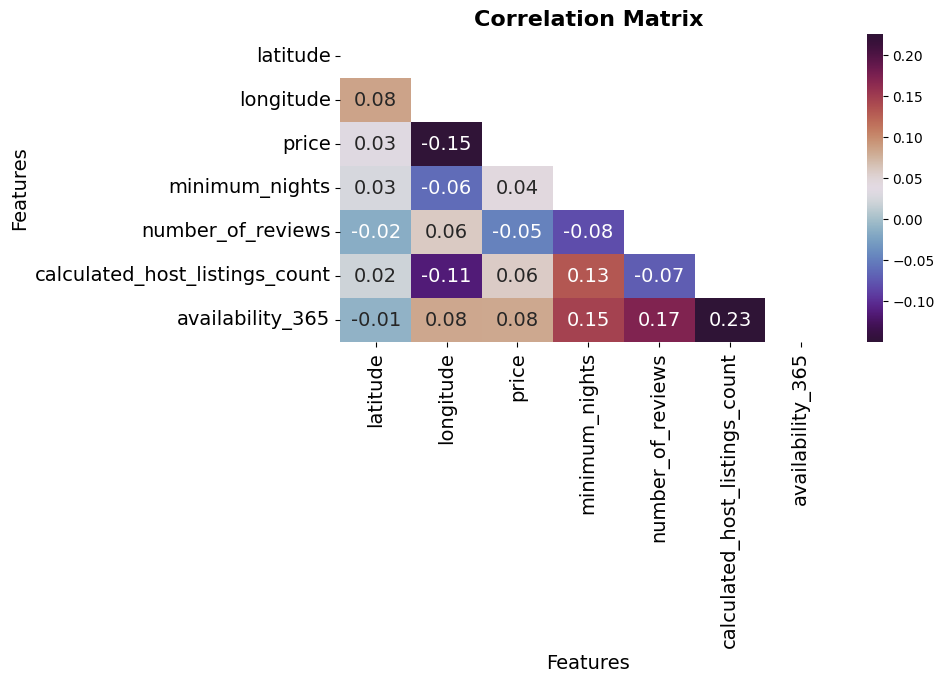

In [210]:
# Numerical columns
columns = ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
           'calculated_host_listings_count', 'availability_365']

# Calling the function
plot_correlation_matrix(airbnb_data, columns)

* Correlation coefficient between "price" and "minimum_nights" is 0.04 which is weak positive relationship. Properties with higher prices tend to have longer minimum stay requirements.

* There is moderate positive correlation between "availability_365" and "calculated_host_listings_count" ie. 0.23.
So hosts with a larger number of listings tend to have higher availability throughout the year.

# Preparing the Data

In [211]:
airbnb_data.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


# Scaling

In [212]:
# listing the columns which requires scaling
cols_to_scale = ['price', 'number_of_reviews']

In [213]:
# Initialising Standard Scaler and applying it on liated columns above
col_scaler = StandardScaler()
airbnb_data[cols_to_scale] = col_scaler.fit_transform(airbnb_data[cols_to_scale])

In [214]:
airbnb_data.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,-0.015570,1,-0.320388,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,0.300794,1,0.487703,2,355
2,Manhattan,40.80902,-73.94190,Private room,-0.011407,3,-0.522411,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,-0.265330,1,5.538271,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,-0.302795,10,-0.320388,1,0


In [215]:
# dropping the categorical columns
airbnb_data = airbnb_data.drop(columns=['neighbourhood_group', 'room_type'])

In [216]:
airbnb_data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,-0.015570,1,-0.320388,6,365
1,40.75362,-73.98377,0.300794,1,0.487703,2,355
2,40.80902,-73.94190,-0.011407,3,-0.522411,1,365
3,40.68514,-73.95976,-0.265330,1,5.538271,1,194
4,40.79851,-73.94399,-0.302795,10,-0.320388,1,0


# Clustering

In [217]:
# Function - for plotting a elbow graph for determining the optimal number of clusters
def plot_elbow_graph(data, max_clusters=10):
    """
    This function plots the Elbow Graph for determining the optimal number of clusters

    Parameters:
    - data: input data for clustering.
    - max_clusters: maximum number of clusters to consider
    """
    # list to store the inertia for each number of clusters
    inertia = []

    # Fitting KMeans
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    # Plotting elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o', color='#BB9AB1', linestyle='--')
    plt.title('Elbow Graph for K-Means Clustering', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=14)
    plt.xticks(range(1, max_clusters + 1), fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.show()

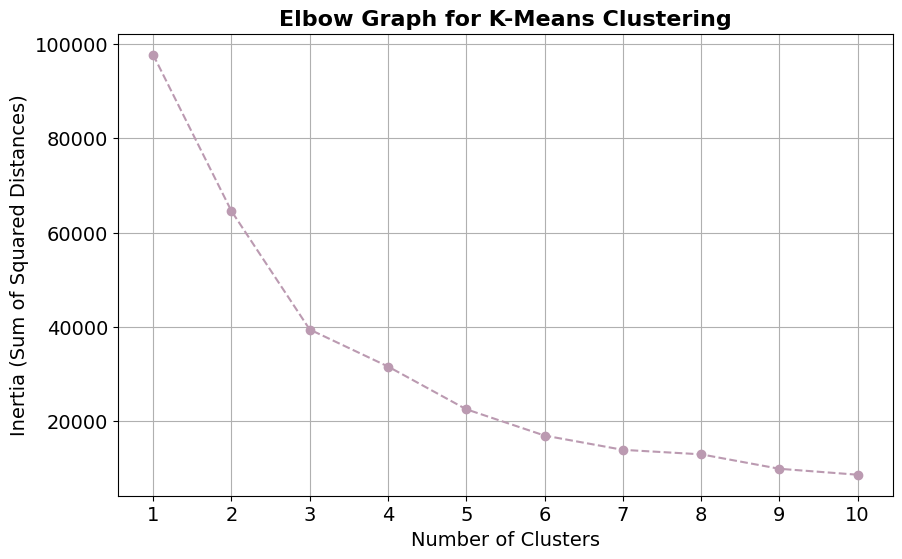

In [218]:
# calling a function
plot_elbow_graph(airbnb_data[cols_to_scale], max_clusters=10)

In [219]:
# defining a function to apply k means
def apply_kmeans(data, n_clusters):
    """
    This function applies K-Means clustering to the data and add the cluster labels to dataframe

    Parameters:
    data: dataframe containing the features to be clustered
    n_clusters: number of clusters to form.

    Returns:
    data: original dtaframe with an additional column 'cluster label'
    """
    # Fitting kmeans clustering model
    df = data.copy()
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df)

    # Adding cluster labels
    df['cluster_label'] = kmeans.labels_

    return df

In [220]:
# calling a function
airbnb_data_with_clusters_col = apply_kmeans(airbnb_data[cols_to_scale], n_clusters=3)

In [221]:
airbnb_data_with_clusters_col.head(3)

,price,number_of_reviews,cluster_label
0,-0.015570,-0.320388,1
1,0.300794,0.487703,1
2,-0.011407,-0.522411,1


In [222]:
# Select the features for clustering
features_to_cluster = ['price',	'number_of_reviews']

# Initialize KMeans model with optimal clusters and fiting
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(airbnb_data[features_to_cluster])

# Getting cluster centers
centers = kmeans.cluster_centers_

In [223]:
# color palette
custom_palette = ['#BB9AB1', '#432E54', '#E07B39']

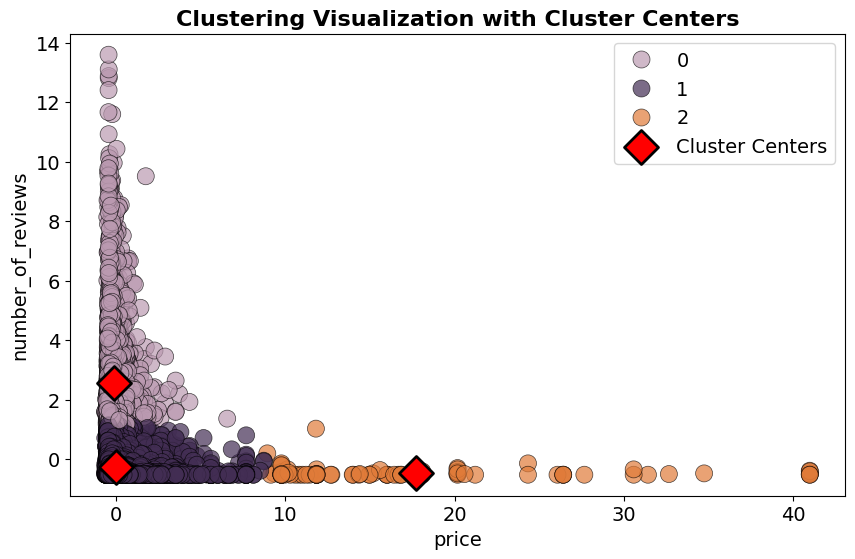

In [224]:
# plotting a scatter plot for clustering visualization with cluster centers
plt.figure(figsize=(10, 6))

# Scatter plot of points
sns.scatterplot(
    x=airbnb_data_with_clusters_col[features_to_cluster[0]],
    y=airbnb_data_with_clusters_col[features_to_cluster[1]],
    hue=airbnb_data_with_clusters_col['cluster_label'],
    palette=custom_palette,
    s=150,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

# Plotting cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, marker='D', label='Cluster Centers', edgecolors='black', linewidths=2)

# Adding title and labels
plt.title('Clustering Visualization with Cluster Centers', fontsize=16, color='black', fontweight='bold')
plt.xlabel(features_to_cluster[0], fontsize=14, color='black')
plt.ylabel(features_to_cluster[1], fontsize=14, color='black')
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.legend(fontsize=14)
plt.show()

* clusters seem to be differentiated by the number of reviews. Cluster 1 contains listings with a higher number of reviews while clusters 0 and 2 have lower review counts.


# GradientBoosting

In [225]:
# Separating the columns
X = airbnb_data_with_clusters_col[features_to_cluster]
y = airbnb_data_with_clusters_col['cluster_label']

In [226]:
# Splitting the datasets into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [227]:
def gradient_boosting_algo(X_train, y_train, random_state=0):
    """
    It trains gradient boosting on the given training dataset

    Args:
    X_train: Features for training
    y_train: Target labels for training
    random_state: Random seed for reproducibility

    Returns:
    gb_classifier: Trained gradient boosting
    """
    gb_model = GradientBoostingClassifier(random_state=random_state)
    gb_model.fit(X_train, y_train)
    return gb_model

In [228]:
# Training model
gb_model = gradient_boosting_algo(X_train, y_train)

In [229]:
gb_model

GradientBoostingClassifier(random_state=0)

In [230]:
# evaluating the performance of teh model
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Printing the performance results
print(f'Training Accuracy: {accuracy_train:.2f}')
print(f'Test Accuracy: {accuracy_test:.2f}')

Training Accuracy: 1.00
Test Accuracy: 1.00


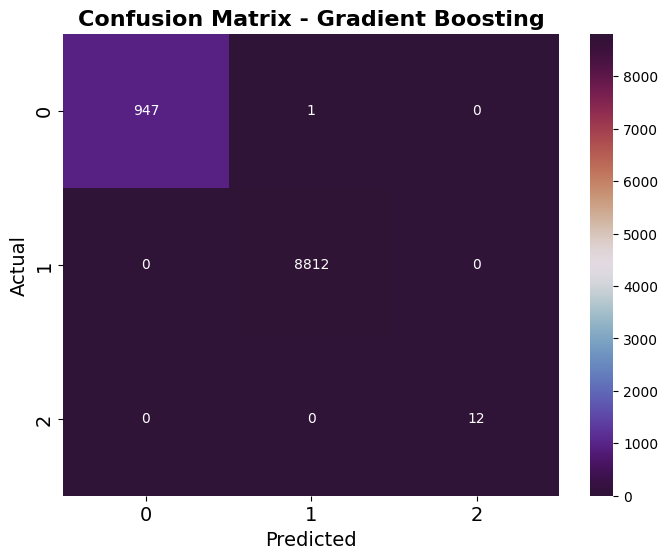

In [231]:
# Computing confusion matrix for Gradient Boosting
conf_matrix_gb = confusion_matrix(y_test, y_pred_test)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='twilight_shifted', xticklabels=gb_model.classes_, yticklabels=gb_model.classes_)
plt.title('Confusion Matrix - Gradient Boosting', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

* This confusion matrix indicates that the Gradient Boosting model performs well, with nearly perfect classification accuracy. Class 1 dominates the dataset as it has classified 8812 samples correctly while classes 0 and 2 have significantly fewer samples 947 and 12 respectively. Only one misclassification is observed between classes 0 and 1.

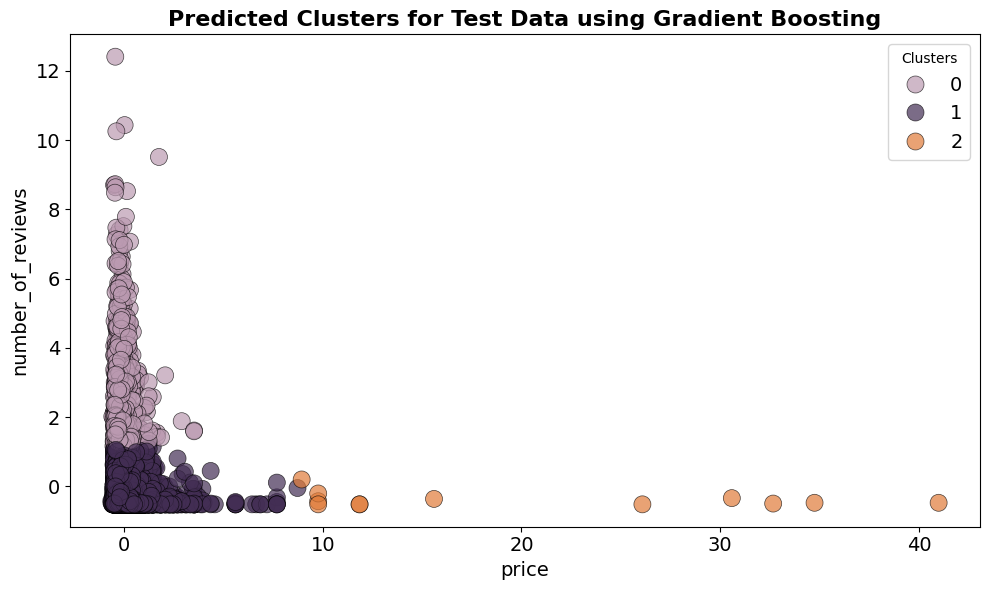

In [232]:
# Visualizing predicted clusters on the test dataset
plt.figure(figsize=(10, 6))

# Scatter plot data points
sns.scatterplot(
    x=X_test[features_to_cluster[0]],
    y=X_test[features_to_cluster[1]],
    hue=y_pred_test,
    palette=custom_palette,
    s=150,
    alpha=0.7,
    edgecolor='black',
    linewidth=0.5
)

# Adding title and labels
plt.title('Predicted Clusters for Test Data using Gradient Boosting', fontsize=16, color='black', fontweight='bold')
plt.xlabel(features_to_cluster[0], fontsize=14, color='black')
plt.ylabel(features_to_cluster[1], fontsize=14, color='black')
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')
plt.legend(fontsize=14, title='Clusters')
plt.tight_layout()
plt.show()

* Gradient Boosting model showsed distinct clustering patterns in the test data with varying separations between clusters, but some overlap indicates possible room for improvement.

# Final Thought

In this project successfully performed the EDA in order to gain the insights about the airbnb data and applied KMeans clustering and Gradient Boosting to analyse and predict data patterns and achieved high accuracy in classification.